#  How to perform functional enrichment analysis on Chip-Seq data?

In [17]:
# Path indication to the loaded packages
import sys
sys.path.insert(0, '/home/usr/Python_venv/lib/python3.8/site-packages/') 

# Loading the modules for data loading
from GRATIOSA import Genome, Chipseq, GO

# Loading the statistical analysis and graphic modules
import numpy as np
from GRATIOSA import stat_analysis, plot_stat_analysis

## 1 - Data loading
#### Genomic annotation loading

In [18]:
g = Genome.Genome("ecoli_W3110_Mu")
g.load_seq()
g.load_annotation()

Trying to load annotation from: /home/maiwenn/these/database/data/ecoli_W3110_Mu/annotation/sequence.gff3
Annotation loaded


#### ChipSeq signal loading

In [19]:
# Initialization of the Chipseq object
ch = Chipseq.Chipseq("ecoli_W3110_Mu")

# Selection of replicates 
cond =["Sutormin_TopoI_R1", "Sutormin_TopoI_R2", "Sutormin_TopoI_R3"]

# The load_signal_average method performs the following two steps:
# 1 - Processes each replicate (here, binning with a chosen binsize)
# 2 - Calculates the average signal between replicates for each genomic position
binsize = 100  # Choice of the binsize (in b) for the binning
cond_name = f"Topo_bin{binsize}b" # Choice of the new signal name
ch.load_signals_average(list_cond=cond,
                        average_name=cond_name,
                        data_treatment="binning",
                        binsize=binsize)
signal_per_bin = ch.signals_average[cond_name][np.arange(0,g.length,binsize)]

loading the file obtained with the following parameters:

Name: Topo_bin100b

 Replicates: ['Sutormin_shift_TopoI_R1', 'Sutormin_shift_TopoI_R2', 'Sutormin_shift_TopoI_R3']

 Data treatment: binning

 Size (window or bin, in b): 100

Please change 'average_name' to use other signals


## 2 - Simplified peak calling and gene selection

#### Selection of bins with the strongest signal using the data classification function

In [20]:
nb_peaks = 100 # Choice of the number of peaks to select

peaks_bin = stat_analysis.data_classification(np.arange(len(signal_per_bin)),
                                              signal_per_bin,
                                              class_nb = 2, 
                                              class_sizes = [len(signal_per_bin)-nb_peaks,nb_peaks]
                                             )[0][1]

0: 46375 elements
1: 100 elements


#### Gene selection (2 options):
+ A: Selection of genes within a chosen window size around each enriched bin

In [21]:
ws = 400 #Choice of the window size ws (in b). 

#Genes located between the start of the peak - ws and the end of the peak + ws are selected
g.load_genes_per_pos(ws*2+binsize)

peak_genes = []
for i in peaks_bin :
    genes = g.genes_per_pos[i*binsize]
    if genes != [None] : 
        peak_genes.extend(genes)
peak_genes =  list(dict.fromkeys(peak_genes))
nopeak_genes = [i for i in list(g.genes.keys()) if i not in peak_genes]

+ B: Selection of the 2 closest genes to each enriched bin

In [22]:
g.load_neighbor_all() #Load, for each position, the closest right and left neighbors

neighbor_genes = []
for i in peaks_bin :
    neighbor_genes.extend([g.left_neighbor[i*binsize],g.right_neighbor[i*binsize]])
neighbor_genes =  list(dict.fromkeys(neighbor_genes))
notneighbor_genes = [i for i in list(g.genes.keys()) if i not in neighbor_genes]

## 3 - Functional enrichment analysis (GO annotation)

#### GO annotation loading

In [23]:
g.load_GO()
dict_GO = g.GO['GO']

Loading GO...
	3739 genes were successfully associated with some GO terms
	927 genes were not associated with any GO term


#### Functional enrichment analysis

In [24]:
genes = {"Peak" : peak_genes, "No peak" : nopeak_genes}  # gene selection made with option A
# genes = {"Peak" : neighbor_genes, "No peak" : notneighbor_genes} # gene selection made with option B

GO.GO_enrichment_test(dict_GO,genes,"Peak",obo_reload=True,
                      output_file=f"GO_enrichment_bin{binsize}b_{nb_peaks}peaks")

Results saved in /home/maiwenn/these/database/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOc.csv
Results saved in /home/maiwenn/these/database/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOp.csv
Results saved in /home/maiwenn/these/database/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_GOf.csv
Results saved in /home/maiwenn/these/database/resdir/enrichment_test/GO_enrichment_bin100b_100peaks_significant.csv


#### Visualization of some enrichment results

GO:0009103: 56 valid elements
GO:0045226: 12 valid elements
GO:0015774: 5 valid elements
Results saved in /home/maiwenn/these/database/resdir/enrichment_test/test1.csv
     Category  Selected_gene_nb  Expected_selected_nb  Adj p-value (FDR)
0  GO:0009103                 9              0.778818       1.311891e-07
1  GO:0045226                 0              0.166890       1.000000e+00
2  GO:0015774                 0              0.069537       1.000000e+00
     Category  Selected_gene_nb  Total_gene_nb  Proportion     Prop_conf_int  \
0  GO:0009103                 9             56    0.160714  [0.1339, 0.1875]   
1  GO:0045226                 0             12    0.000000     [0.0, 0.0417]   
2  GO:0015774                 0              5    0.000000        [0.0, 0.1]   

        p-value  Adj p-value (FDR)  Global_proportion  Expected_selected_nb  
0  4.372971e-08       1.311891e-07           0.013907              0.778818  
1  1.000000e+00       1.000000e+00           0.013907          

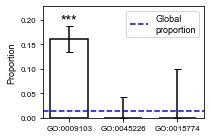

In [25]:
plot_stat_analysis.plot_enrichment_test(
    dict_GO,genes,
    targ_features=["Peak"],
    targ_cats=["GO:0009103","GO:0045226","GO:0015774"],
    figsize = (3,2),
    output_file="test1")